In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
data = pd.read_csv(r'D:\NEU\Năm 3\ML\GitHub ML\Machine-Learning-1\Naive Bayes\ung thư.csv')
data.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


In [9]:
data.diagnosis.unique()

array([0, 1], dtype=int64)

# Basic EDA

<AxesSubplot:>

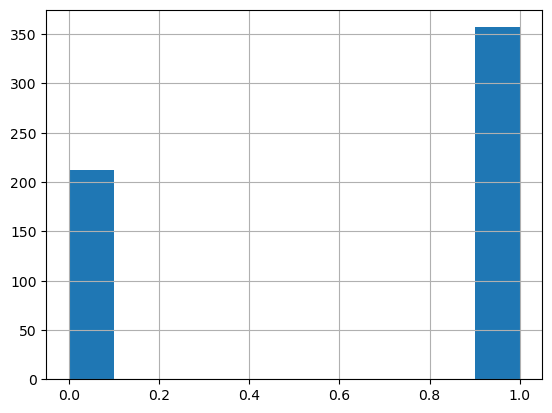

In [13]:
data['diagnosis'].hist()

**Check if features are independent**

- We know that to apply Naive Bayes Classifier, features must be independent of each other .

- WHY ?

- Because in Naive Bayes Classifier the assumption is the features are independent

<AxesSubplot:>

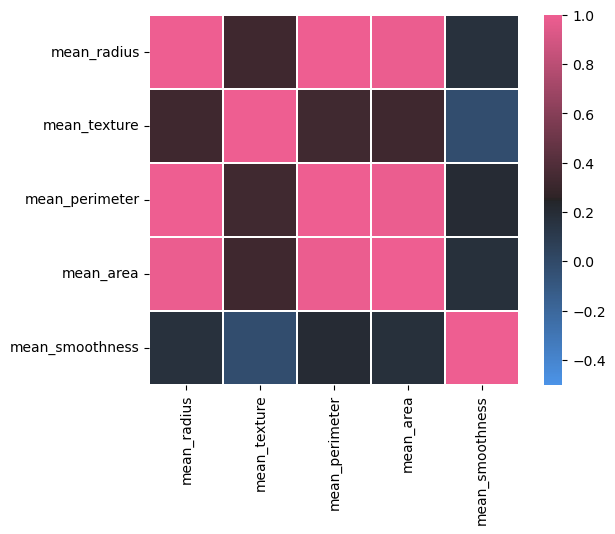

In [14]:
corr = data.iloc[:,:-1].corr(method='pearson')
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr,vmax=1,vmin = -0.5, cmap=cmap, square=True,linewidths=0.2)

**It is obvious that we should not have area and radius and perimeter in the same data(correlation is approximate 1). Should take only one feature in these 3 features to bring to the model**

In [17]:
# Keep the mean radius and remove two others
data = data[['mean_radius','mean_texture','mean_smoothness','diagnosis']]
data.head(10)

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
5,12.45,15.70,0.12780,0
6,18.25,19.98,0.09463,0
7,13.71,20.83,0.11890,0
8,13.00,21.82,0.12730,0
9,12.46,24.04,0.11860,0


<AxesSubplot:xlabel='mean_texture', ylabel='Count'>

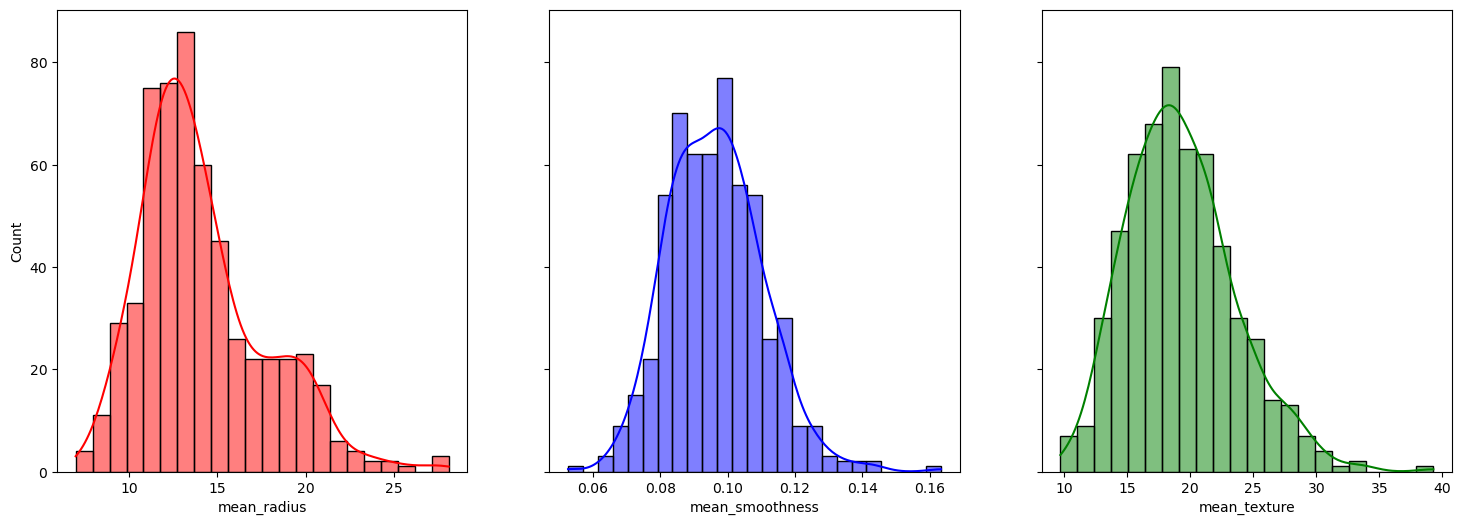

In [29]:
fig,axes = plt.subplots(1,3,figsize = (18,6), sharey=True)
sns.histplot(data, ax=axes[0], x='mean_radius',kde=True,color='r')
sns.histplot(data, ax=axes[1], x='mean_smoothness',kde=True,color='b')
sns.histplot(data, ax=axes[2], x='mean_texture',kde=True,color='g')

**Nhận xét : mean_texture and mean_smoothness and mean_radius almost have the normal distribution shape so we should fit a normal distribution to these features**

**REMIND NAIVE BAYES CLASSIFIER: **

$${decisionGroup} = arg max_c P(X|c).P(c) = arg max_c (likelihood . prior)$$ 

# Calculate P(Y=y) for all possible y

In [47]:
def calculate_prior(df,Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

# Approach 1: Calculate P(X=x|Y=y) using Gaussian dist

In [48]:
def calculate_likelihood_gaussian(df,feat_name,feat_val,Y,label):
    feat = list(df.columns)
    df = df[df[Y]==label]  # Taking only data point where df[Y] equal label
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1/(np.sqrt(2*np.pi)*std)) * np.exp(-((feat_val - mean)**2 / (2 * std**2)))
    return p_x_given_y

## Calculate P(X=x1|Y=y).P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maxium

In [49]:
def naive_bayes_gaussian(df,X,Y):
    features = list(df.columns)[:-1]
    
    # calculate prior
    prior = calculate_prior(df,Y)
    
    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1] * len(labels)
        for j in range(len(labels)): # travel every class
            for i in range(len(features)):# travel every feature
                likelihood[j] *= calculate_likelihood_gaussian(df,features[i],x[i],Y,labels[j])
        
        # calculate posterior probability (numerator only)
        post_prob = [1] * len(labels)
        for j in range(len(labels)): 
            post_prob[j] = likelihood[j] * prior[j] 
        
        Y_pred.append(np.argmax(post_prob))
    
    return np.array(Y_pred)

## Test Gaussian model

In [50]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data,test_size=0.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train,X=X_test,Y='diagnosis')

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[36  4]
 [ 0 74]]
0.9736842105263158


# Approach 2: Calculate P(X=x|Y=y) categorically

In [51]:
data['cat_mean_radius'] = pd.cut(data['mean_radius'].values, bins = 3, labels = [0,1,2])
data['cat_mean_texture'] = pd.cut(data['mean_texture'].values, bins = 3, labels = [0,1,2])
data['cat_mean_smoothness'] = pd.cut(data['mean_smoothness'].values, bins = 3, labels = [0,1,2])

data = data.drop(columns = ['mean_radius','mean_texture','mean_smoothness'])
data = data[['cat_mean_radius','cat_mean_texture','cat_mean_smoothness','diagnosis']]
data.head(10)

,cat_mean_radius,cat_mean_texture,cat_mean_smoothness,diagnosis
0,1,0,1,0
1,1,0,0,0
2,1,1,1,0
3,0,1,2,0
4,1,0,1,0
5,0,0,2,0
6,1,1,1,0
7,0,1,1,0
8,0,1,2,0
9,0,1,1,0


## Calculate likelihood categorical

In [52]:
def calculate_likelihood_categorical(df,feat_name,feat_val,Y,label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val])/len(df)
    return p_x_given_y

## Calculate P(X=x1|Y=y).P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maxium¶

In [57]:
def naive_bayes_categorical(df,X,Y):
    features = list(df.columns)[:-1]
    
    # calculate prior
    prior = calculate_prior(df,Y)
    
    Y_pred = []
    # loop over every data sample
    for x in X:
        labels = sorted(list(df[Y].unique()))
        likelihood = [1] * len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df,features[i],x[i],Y,labels[j])
                
        # calculate posterior probability (numerator only)
        post_prob = [1] * len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]
        
        Y_pred.append(np.argmax(post_prob))
    
    return np.array(Y_pred)

## Test Categorical Model

In [59]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data,test_size=0.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train,X=X_test,Y='diagnosis')

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[38  2]
 [ 5 69]]
0.9517241379310345
